<a href="https://colab.research.google.com/github/negbuna/healthcare-bias/blob/main/CHD_bias_with_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Cardiovascular Risk with Fairness in Mind  
Nathan Egbuna — Summer 2025 Research Project

This notebook explores how model choice and demographic balance affect fairness and performance in heart disease prediction models.

In [ ]:
!pip install opendatasets
import opendatasets as od
import pandas as pd

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
framingham_dataset = "https://www.kaggle.com/datasets/aasheesh200/framingham-heart-study-dataset"
od.download(framingham_dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: negbuna
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/aasheesh200/framingham-heart-study-dataset


100%|██████████| 58.0k/58.0k [00:00<00:00, 45.2MB/s]

In [ ]:
df = pd.read_csv('/content/framingham-heart-study-dataset/framingham.csv')
df = df.dropna()
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3658 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3658 non-null   int64  
 1   age              3658 non-null   int64  
 2   education        3658 non-null   float64
 3   currentSmoker    3658 non-null   int64  
 4   cigsPerDay       3658 non-null   float64
 5   BPMeds           3658 non-null   float64
 6   prevalentStroke  3658 non-null   int64  
 7   prevalentHyp     3658 non-null   int64  
 8   diabetes         3658 non-null   int64  
 9   totChol          3658 non-null   float64
 10  sysBP            3658 non-null   float64
 11  diaBP            3658 non-null   float64
 12  BMI              3658 non-null   float64
 13  heartRate        3658 non-null   float64
 14  glucose          3658 non-null   float64
 15  TenYearCHD       3658 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 485.8 KB


In [ ]:
# Separate patients into education groups
df['edu_group'] = df['education'].fillna(0).apply(lambda x: 'Low' if x <= 2 else 'Medium' if x == 3 else 'High')

# One-hot encoding for the edu_group column
df = pd.get_dummies(df, columns=['edu_group'], drop_first=True) # Use drop_first to avoid multicollinearity

In [ ]:
X = df.drop(columns=['TenYearCHD', 'education']) # Dropping the target and education (already sorted)
y = df['TenYearCHD']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
lr_model = LogisticRegression(max_iter=2000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8620218579234973


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
gender = X_test['male'].reset_index(drop=True)
y_true = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred).reset_index(drop=True)

# Make a dataframe to merge predictions with gender
df_results = pd.DataFrame({
    'true': y_true,
    'pred': y_pred,
    'male': gender
})

In [ ]:
def get_confusion_stats(group_df):
    tp = ((group_df['pred'] == 1) & (group_df['true'] == 1)).sum()
    tn = ((group_df['pred'] == 0) & (group_df['true'] == 0)).sum()
    fp = ((group_df['pred'] == 1) & (group_df['true'] == 0)).sum()
    fn = ((group_df['pred'] == 0) & (group_df['true'] == 1)).sum()
    return tp, tn, fp, fn

In [ ]:
# Separate male and female data
male_df = df_results[df_results['male'] == 1]
female_df = df_results[df_results['male'] == 0]

tp_m, tn_m, fp_m, fn_m = get_confusion_stats(male_df)
tp_f, tn_f, fp_f, fn_f = get_confusion_stats(female_df)

In [ ]:
# Calculate true positive rate
tpr_m = tp_m / (tp_m + fn_m)  # Male
tpr_f = tp_f / (tp_f + fn_f)  # Female
print(f"True Positive Rate (Male): {tpr_m}")
print(f"True Positive Rate (Female): {tpr_f}")

eod = tpr_m - tpr_f  # Equal opportunity difference
print(f"Equal Opportunity Difference: {eod}")

# Calculate accuracy (All true negatives + positives / total)
acc_m = (tp_m + tn_m) / len(male_df)
acc_f = (tp_f + tn_f) / len(female_df)
print(f"Accuracy (Male): {acc_m}")
print(f"Accuracy (Female): {acc_f}")

# Calculate demographic parity difference
dpd = acc_m - acc_f
print(f"Demographic Parity Difference: {dpd}")

True Positive Rate (Male): 0.17391304347826086
True Positive Rate (Female): 0.09523809523809523
Equal Opportunity Difference: 0.07867494824016563
Accuracy (Male): 0.8105590062111802
Accuracy (Female): 0.9024390243902439
Demographic Parity Difference: -0.09188001817906377


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

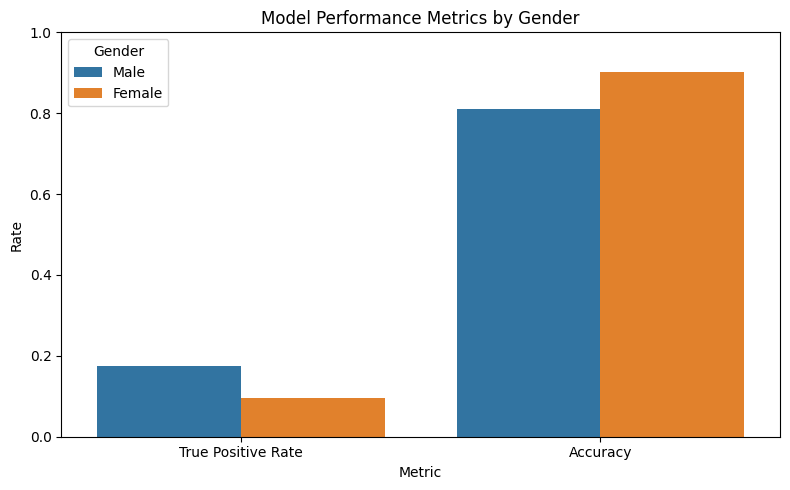

In [ ]:
# TPR and accuracy plots
metrics = ['True Positive Rate', 'Accuracy']
male_vals = [tpr_m, acc_m]
female_vals = [tpr_f, acc_f]

df_plot = pd.DataFrame({
    'Metric': metrics * 2,
    'Gender': ['Male'] * 2 + ['Female'] * 2,
    'Value': male_vals + female_vals
})

plt.figure(figsize=(8,5))
sns.barplot(data=df_plot, x='Metric', y='Value', hue='Gender')
plt.title('Model Performance Metrics by Gender')
plt.ylim(0,1)
plt.ylabel('Rate')
plt.tight_layout()
plt.show()

In [ ]:
plt.savefig('tpr_acc.png')

<Figure size 640x480 with 0 Axes>

<ipython-input-45-0f5e2a0de013>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(fairness_metrics.keys()), y=list(fairness_metrics.values()), palette="muted")


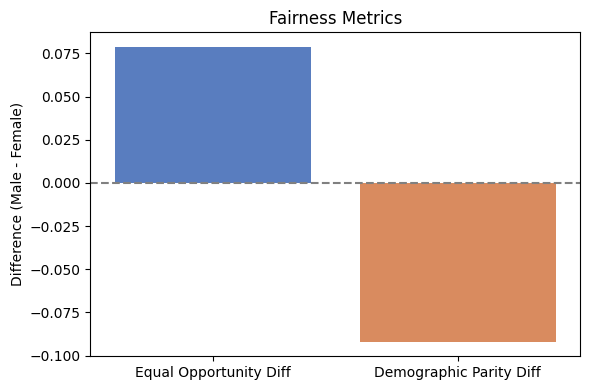

In [ ]:
# EOD and DPD plots
fairness_metrics = {
    'Equal Opportunity Diff': eod,
    'Demographic Parity Diff': dpd
}

plt.figure(figsize=(6,4))
sns.barplot(x=list(fairness_metrics.keys()), y=list(fairness_metrics.values()), palette="muted")
plt.axhline(0, color='gray', linestyle='--')
plt.title('Fairness Metrics')
plt.ylabel('Difference (Male - Female)')
plt.tight_layout()
plt.show()

In [ ]:
plt.savefig('eod_dpd.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
def make_confusion_matrix(group_df, gender_value):
    # 1 for male, 0 for female
    group = group_df[group_df['male'] == gender_value]

    y_true = group['true']
    y_pred = group['pred']

    cm = confusion_matrix(y_true, y_pred)

    gender = "Male" if gender_value == 1 else "Female"
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{gender} Confusion Matrix')
    plt.show()

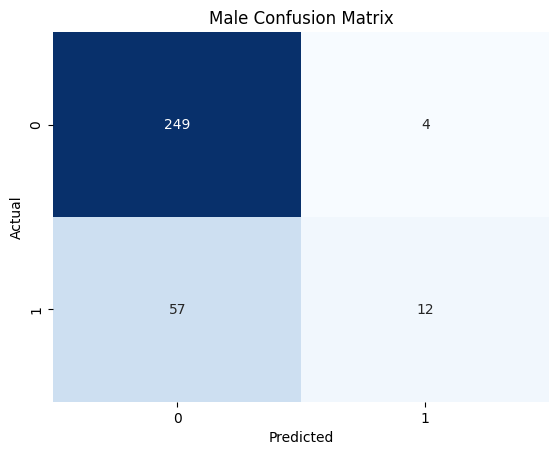

In [ ]:
make_confusion_matrix(df_results, 1)

In [ ]:
plt.savefig('conf_matrix_male.png')

<Figure size 640x480 with 0 Axes>

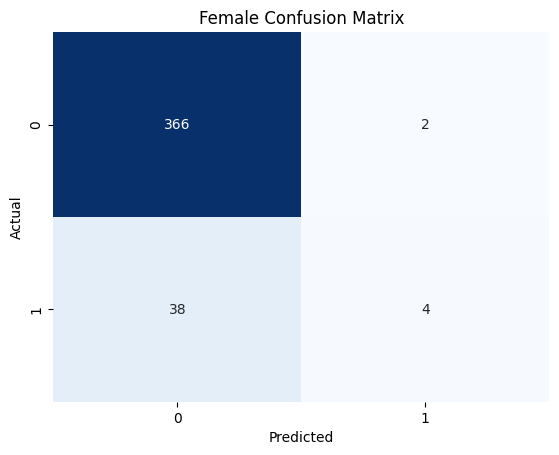

In [ ]:
make_confusion_matrix(df_results, 0)

In [ ]:
plt.savefig('conf_matrix_female.png')

<Figure size 640x480 with 0 Axes>